The MNIST dataset contains tens of thousands of scanned images of handwritten digits, together with their correct classifications. MNIST's name comes from the fact that it is a modified subset of two data sets collected by NIST, the United States' National Institute of Standards and Technology.<br>
<br>
<br>
To use Keras, you'll need to install Keras and Tensorflow.
<br>
Please run the following commands if you don't have Keras and TensorFlow already installed.
<br>
1. ! pip install TensorFlow
<br>
2. ! pip install keras
<br>
3. ! pip install msgpack


In [1]:
import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sklearn
import sklearn.datasets
import scipy

from PIL import Image
from scipy import ndimage


from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras import regularizers

np.random.seed(7)


%matplotlib inline

The MNIST dataset we use here is 'mnist.pkl.gz' which is divided into training, validation and test data. The following function <i> load_data() </i> unpacks the file and extracts the training, validation and test data.

In [4]:
def load_data():
    f = gzip.open('mnist.pkl.gz', 'rb')
    f.seek(0)
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    return (training_data, validation_data, test_data)

Let's see how the data looks:

In [5]:
training_data, validation_data, test_data = load_data()

In [6]:
training_data

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([5, 0, 4, ..., 8, 4, 8], dtype=int64))

In [7]:
print("The feature dataset is:" + str(training_data[0]))
print("The target dataset is:" + str(training_data[1]))
print("The number of examples in the training dataset is:" + str(len(training_data[0])))
print("The number of points in a single input is:" + str(len(training_data[0][1])))

The feature dataset is:[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
The target dataset is:[5 0 4 ... 8 4 8]
The number of examples in the training dataset is:50000
The number of points in a single input is:784


Now, as discussed earlier in the lectures, the target variable is converted to a one hot matrix. We use the function <i> one_hot </i> to convert the target dataset to one hot encoding.

In [8]:
def one_hot(j):
    # input is the target dataset of shape (1, m) where m is the number of data points
    # returns a 2 dimensional array of shape (10, m) where each target value is converted to a one hot encoding
    # Look at the next block of code for a better understanding of one hot encoding
    n = j.shape[0]
    new_array = np.zeros((10, n))
    index = 0
    for res in j:
        new_array[res][index] = 1.0
        index = index + 1
    return new_array

In [9]:
data = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
one_hot(data)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [10]:
def data_wrapper():
    tr_d, va_d, te_d = load_data()
    
    training_inputs = np.array(tr_d[0][:]).T
    training_results = np.array(tr_d[1][:])
    train_set_y = one_hot(training_results)
    
    validation_inputs = np.array(va_d[0][:]).T
    validation_results = np.array(va_d[1][:])
    validation_set_y = one_hot(validation_results)
    
    test_inputs = np.array(te_d[0][:]).T
    test_results = np.array(te_d[1][:])
    test_set_y = one_hot(test_results)
    
    return (training_inputs, train_set_y, validation_inputs, validation_set_y)

In [11]:
train_set_x, train_set_y, test_set_x, test_set_y = data_wrapper()

For implementing in Keras, the input training and input target dataset are supposed to have shape (m, n) where m is the number of training samples and n is the number of parts in a single input.
<br> Hence, let create the desired dataset shapes by taking transpose.

In [12]:
train_set_x = train_set_x.T
train_set_y = train_set_y.T
test_set_x = test_set_x.T
test_set_y = test_set_y.T

Now, let's see if the datasets are in the desired shape:

In [13]:
print ("train_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x shape: (50000, 784)
train_set_y shape: (50000, 10)
test_set_x shape: (10000, 784)
test_set_y shape: (10000, 10)


Now let us visualise the dataset. Feel free to change the index to see if the training data has been correctly tagged.

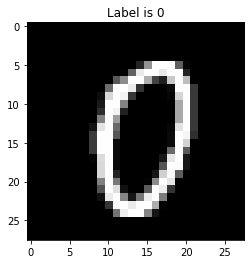

In [14]:
index  = 1000
k = train_set_x[index,:]
k = k.reshape((28, 28))
plt.title('Label is {label}'.format(label= training_data[1][index]))
plt.imshow(k, cmap='gray')

Keras is a framework. So, to implement a neural network model in Keras, we first create an instance of Sequential(). <br>
The Sequential model is a linear stack of layers. We then keep adding Dense layers that are fully connected layers as we desire.<br><br>
We have included Dropout using <i> nn_model.add(Dropout(0.3)) </i> <br><br>
We can also include regularization using the command <br> <i> nn_model.add(Dense(21, activation='relu', kernel_regularizer=regularizers.l2(0.01))) </i> <br>instead of <br> <i> nn_model.add(Dense(21, activation='relu')) </i>

In [15]:
# create model
nn_model = Sequential()
nn_model.add(Dense(35, input_dim=784, activation='relu'))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(21, activation = 'relu'))
nn_model.add(Dense(10, activation='softmax'))

Before we run the model on the training datasets, we compile the model in which we define various things like the loss function, the optimizer and the evaluation metric.

In [16]:
nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Now, to fit the model on the training input and training target dataset, we run the following command using a minibatch of size 10 and 10 epochs.

In [17]:
nn_model.fit(train_set_x, train_set_y, epochs=10, batch_size=10)

Epoch 1/10
5000/5000 [==============================] - 5s 890us/step - loss: 0.7407 - accuracy: 0.7634
Epoch 2/10
5000/5000 [==============================] - 5s 922us/step - loss: 0.3246 - accuracy: 0.8991
Epoch 3/10
5000/5000 [==============================] - 5s 950us/step - loss: 0.2813 - accuracy: 0.9132
Epoch 4/10
5000/5000 [==============================] - 5s 902us/step - loss: 0.2636 - accuracy: 0.9203
Epoch 5/10
5000/5000 [==============================] - 4s 881us/step - loss: 0.2426 - accuracy: 0.9236
Epoch 6/10
5000/5000 [==============================] - 4s 885us/step - loss: 0.2348 - accuracy: 0.9256
Epoch 7/10
5000/5000 [==============================] - 5s 905us/step - loss: 0.2262 - accuracy: 0.9281
Epoch 8/10
5000/5000 [==============================] - 4s 893us/step - loss: 0.2166 - accuracy: 0.9312
Epoch 9/10
5000/5000 [==============================] - 5s 944us/step - loss: 0.2072 - accuracy: 0.9343
Epoch 10/10
5000/5000 [==============================] - 5s 987u

In [18]:
scores_train = nn_model.evaluate(train_set_x, train_set_y)
print("\n%s: %.2f%%" % (nn_model.metrics_names[1], scores_train[1]*100))

1563/1563 [==============================] - 1s 716us/step - loss: 0.1071 - accuracy: 0.96690s - l

accuracy: 96.69%


We can see that the model has ~ 97% accuracy on the training dataset.

Now, let's make predictions on the test dataset.

In [19]:
predictions = nn_model.predict(test_set_x)
predictions = np.argmax(predictions, axis = 1)
predictions

array([3, 8, 6, ..., 5, 6, 8], dtype=int64)

In [20]:
scores_test = nn_model.evaluate(test_set_x, test_set_y)
print("\n%s: %.2f%%" % (nn_model.metrics_names[1], scores_test[1]*100))

313/313 [==============================] - 0s 776us/step - loss: 0.1391 - accuracy: 0.9607

accuracy: 96.07%


We can see that the model has ~96% accuracy on the test dataset.

Try and look at the different test cases and check which all have gone wrong. Feel free to change the index numbers.

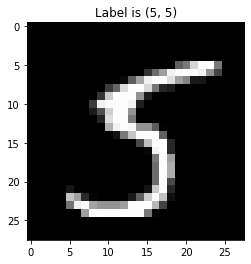

In [21]:
index  = 9997
k = test_set_x[index, :]
k = k.reshape((28, 28))
plt.title('Label is {label}'.format(label=(predictions[index], np.argmax(test_set_y, axis = 1)[index])))
plt.imshow(k, cmap='gray')